## Imports, hyperparam set, data prep

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as f
from nltk.tokenize import word_tokenize
import pandas as pd
torch.cuda.is_available()


True

In [24]:
import plotly.express as px

In [25]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ghosh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
msp=open("fairyTales.txt",encoding="utf-8")
corpus=msp.read()

In [27]:
corpus=word_tokenize(corpus.lower())
wordToTok={}
tokToWord={}
i=0
for word in set(corpus):
   word=word
   tokToWord[i]= word
   wordToTok[word]=i
   i=i+1

In [28]:
block=8
embed_dim=2
hidden_dim=2000
vocab=len(set(corpus))
batch=500

In [29]:
vocab

5776

In [30]:
X1=[]
Y1=[]
j=0
i=block
context=[]
while j<i:
    context.append(wordToTok[corpus[j]])
    j=j+1

X1.append(context)
Y1.append(wordToTok[corpus[i]])

while i<len(corpus)-1:
    i=i+1
    context=context[1:]
    context.append(wordToTok[corpus[i-1]])
    X1.append(context)
    Y1.append(wordToTok[corpus[i]])

## Defining Layers and Pipes

In [31]:
from typing import Any

class flatten:
    def __init__(self):
        pass
    
    def __call__(self,x)->torch.Tensor:
        return x.view(-1,x.shape[-1]*x.shape[-2])
    
    def returnParams(self):
        return []  


class embed:
    
    #initialize embedding table on call
    def __init__(self,inSize,emSize):
        device="cuda" if torch.cuda.is_available() else "cpu"
        self.Table=torch.rand((inSize,emSize),device=device)/inSize**0.5
    
    
    # Setting up the index look ups
    def __call__(self, X):
        return self.Table[X]

    #Setting up returning params
    def returnParams(self):
        return [self.Table]
    

class linear:
    
    #initialize embedding table on call
    def __init__(self,inSize,outSize,device=None,bias=True):
        self.bias=bias
        device="cuda" if torch.cuda.is_available() else "cpu"
        self.Weights=torch.rand((inSize,outSize),device=device)/inSize**0.5
        if bias:
            self.Bias=torch.rand((outSize),device=device)
    
    # Setting up the index look ups
    def __call__(self, X):
        if self.bias:
            return X@self.Weights+self.Bias
        else:
            return X@self.Weights

    #Setting up returning params
    def returnParams(self):
        if self.bias:
            return [self.Weights,self.Bias]
        else:
            return [self.Weights]


class tanh:
    
    def __init__(self) -> None:
        pass
    
    def __call__(self,X) -> torch.Tensor:
        return f.tanh(X)
    
    def returnParams(self):
        return []
    
    
class elu:
    
    def __init__(self) -> None:
        pass
    
    def __call__(self,X) -> torch.Tensor:
        return f.elu(X)
    
    def returnParams(self):
        return []
    
class relu:
    
    def __init__(self) -> None:
        pass
    
    def __call__(self,X) -> torch.Tensor:
        return f.relu(X)
    
    def returnParams(self):
        return []

In [32]:
class Pipeline:
    
    def __init__(self,layers) -> None :
        self.layers=[]
        for layer in layers:
            self.layers.append(layer)
    
    def __call__(self,x) -> torch.tensor:
        for layer in self.layers:
            x=layer(x)
        return x

    def getParams(self) ->list:
        params=[]
        for layer in self.layers:
            params=params+layer.returnParams()
        return params
    
    def FlaggedCall(self,x,flags):
        i=0
        arr=[]
        for layer in self.layers:
            x=layer(x)
            if i in flags:
                arr.append(x)
            i=i+1
        return [x,arr]
    
    def saveModel(self,name):
        i=0
        for layer in self.layers:
            params=layer.returnParams()
            if params!=[]:
                for p in params:
                    torch.save(p,name+"_"+str(i)+".pt")
                    i=i+1
                
        
        
        

## Putting everything together

Tensor Init

In [33]:
torch.set_grad_enabled(True)

In [34]:
X=torch.tensor(X1,device='cuda')
Y=torch.tensor(Y1,device='cuda')

Metrics Init

In [35]:
Neuron_fire_track=[]
loss_hist=[]

Defining the pipe

In [36]:
layers=[embed(vocab,embed_dim),flatten(),linear(embed_dim*block,hidden_dim),tanh(),linear(hidden_dim,vocab)]
pipe=Pipeline(layers=layers)
params=pipe.getParams()
for p in params:
    p.requires_grad= True

In [51]:
for i in range(4000):#no. of epochs
    batch_index=torch.randint(0,Y.shape[0],(batch,),device='cuda')
    Xb=X[batch_index,:]
    Yb=Y[batch_index]

    logits=pipe(Xb)
    loss=f.cross_entropy(logits,Yb)
    loss_hist.append(loss.item())

    for p in params:
        p.grad=None

    loss.backward()

    for p in params:
        #lr= 0.1 if i<500 else (0.01 if i<1000 else 0.001)
        lr=0.05
        p.data-=lr*p.grad

<Axes: >

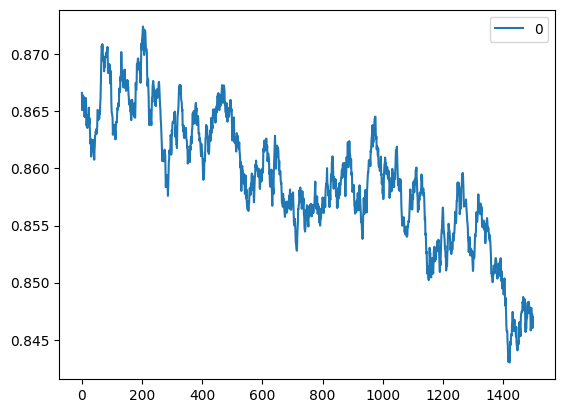

In [53]:
mar=[]
stride=100
for i in range(len(loss_hist)-stride):
    mar.append(sum(loss_hist[i:i+stride])/stride)
sns.lineplot([mar[-1500:]])

## Taking the model on a spin

In [54]:
import copy

In [55]:
def predict_next(context):
    context_tok=[]
    for i in context:
        context_tok.append(wordToTok[i.lower()])
    x=torch.tensor(context_tok,requires_grad = False)
    x=pipe(x)
    return(tokToWord[torch.argmax(x).item()])

def gen(string):
    context=string.split()[:block]
    words=copy.copy(context)
    for _ in range(50):
        next_word=predict_next(context)
        words.append(next_word)
        context=context[1:]
        context.append(next_word)
    string=""
    for i in words:
        string=string+i+" "
    print(string)

In [56]:
gen("the big dog sat at the table said")

the big dog sat at the table said , ‘ that is the masters. ’ s son was equally alarmed , and he fell so that if she had not a sound of the old said , ‘ there is going ; when you will go you will be was able to the gallows , and said , 


In [59]:
gen("the country is known for the big and")

the country is known for the big and settled , the woman beast springs , and said : ‘ what do you desire ? ’ ‘ what do you see that no my little little man ! who it and his head and a shame , and there lay that pertains to it. ’ scarcely there hans in 


## Visualizing the model

In [60]:
data_list = copy.copy(pipe.getParams()[0]).cpu().detach().numpy().tolist()
labels=[""]*vocab

for i in range(vocab):
    labels[i]=tokToWord[i]


df = pd.DataFrame(data_list, columns=[f'Column_{i}' for i in range(1, embed_dim + 1)])
df.insert(0, 'Labels', labels)

# Display the DataFrame
df.head()

df.to_csv("Embedding table grimms fairy dim 2.csv")

In [63]:
# Plot the t-SNE results using Plotly
fig = px.scatter(df, x='Column_1', y='Column_2', color='Labels', title='t-SNE Visualization',
                 labels={'Dimension 1': 'Column_1', 'Dimension 2': 'Column_2', 'Labels': 'Labels'})
fig.show()